In [2]:
import pandas as pd
from utils.data_loader import load_data

df, config, features = load_data()

In [3]:
if config['is_adult']:
    df.to_csv(("all_cohorts_adults.csv"), index=False)
else:
    df.to_csv(("all_cohorts_children.csv"), index=False)

In [4]:
def prediction_data_pruner(df, threshold=0):
    """Remove data rows based on the threshold of missing values."""
    data = df
    mandatory_columns = ['Fibrinogen_g_L', 'LDH_UI_L', 'WBC_G_L', 'Lymphocytes_G_L',
    'MCHC_g_L', 'MCV_fL', 'Monocytes_G_L', 'Platelets_G_L',
    'PT_percent']
    
    ['MCV_fL', 'PT_percent', 'LDH_UI_L', 'MCHC_g_L', 'WBC_G_L', 'Fibrinogen_g_L', 'Monocytes_G_L', 'Platelets_G_L', 'Lymphocytes_G_L']

    data["nan_percentage"] = data[mandatory_columns].isna().mean(axis=1)

    # Prune data where the percentage of NaN values is above the threshold
    data = data[data["nan_percentage"] <= threshold]
    data.drop(columns=["nan_percentage"], inplace=True)
    return data


/tmp/ipykernel_4129286/3935863735.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=["nan_percentage"], inplace=True)


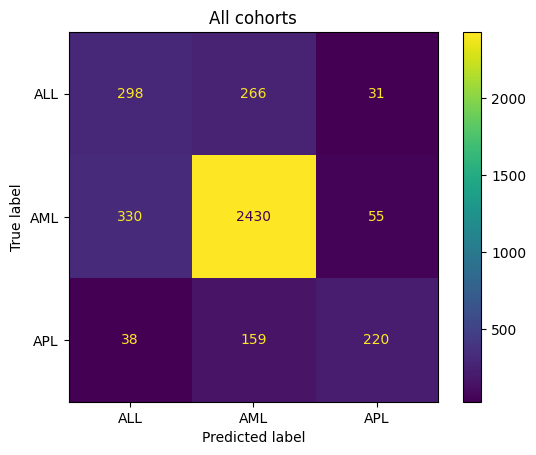

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure predictions are in float format
df[["prediction.ALL", "prediction.AML", "prediction.APL"]] = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

# Prune the prediction data based on the threshold
df = prediction_data_pruner(df, threshold=0.2)

# Identify the column with the maximum prediction value
df["max_pred"] = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].idxmax(axis=1)
df["max_pred"] = df["max_pred"].str.split(".").str[1]  # Extract the class name

# Generate the confusion matrix display
disp = ConfusionMatrixDisplay.from_predictions(df["class"], df["max_pred"])

# Adding a title to the confusion matrix
disp.ax_.set_title("All cohorts")

# Show the plot
plt.show()

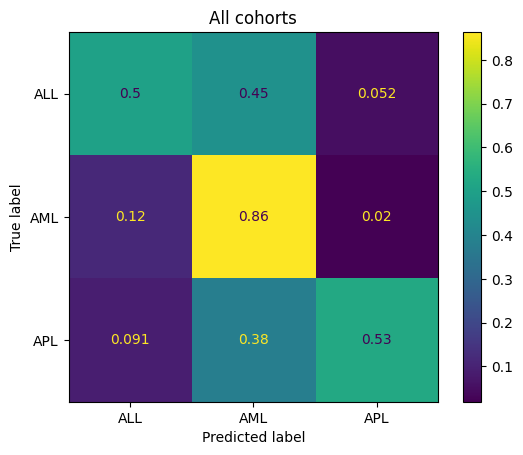

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the normalized confusion matrix display
disp = ConfusionMatrixDisplay.from_predictions(df["class"], df["max_pred"], normalize='true')

# Adding a title to the normalized confusion matrix
disp.ax_.set_title("All cohorts")

# Show the plot
plt.show()

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

# Binarize the class labels
classes = df['max_pred'].unique()
y = label_binarize(df['class'], classes=classes)
n_classes = y.shape[1]

# Ensure the predictions are in the correct order
y_score = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

# Calculate the AUC for each class
auc_scores = []
for i in range(n_classes):
    # Calculate AUC using true binary labels vs. prediction scores for class i
    auc_score = roc_auc_score(y[:, i], y_score[:, i])
    auc_scores.append(auc_score)
    print(f"AUC for {classes[i]}: {auc_score}")

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")

AUC for AML: 0.3263628641032301
AUC for ALL: 0.24847117064647642
AUC for APL: 0.922282467281307
Average AUC: 0.49903883401033783


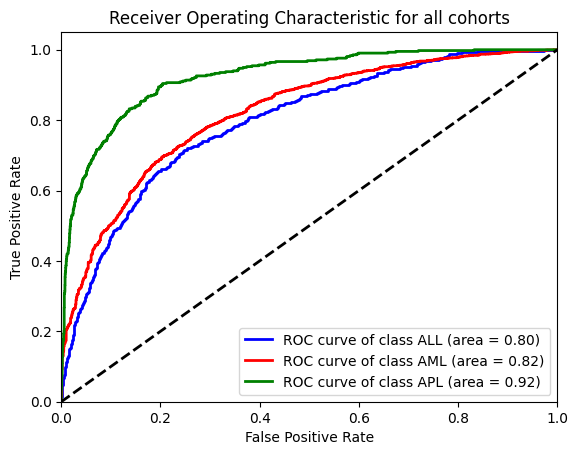

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has been processed as per your selection

# Binarize the class labels
# classes = df['max_pred'].unique()
classes = ["ALL", "AML", "APL"]
y = label_binarize(df['class'], classes=classes)
n_classes = y.shape[1]

# Convert predictions to a similar format for ROC calculation
y_score = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all cohorts')
plt.legend(loc="lower right")
plt.show()

In [9]:
df

,ID,age,sex,class,MCV_fL,PT_percent,LDH_UI_L,MCHC_g_L,WBC_G_L,Fibrinogen_g_L,Monocytes_G_L,Platelets_G_L,Lymphocytes_G_L,Monocytes_percent,prediction.ALL,prediction.AML,prediction.APL,city_country,max_pred
0,UTSW 1,75.68,Male,AML,90.7,88.44391,897.0,324.0,183.70,3.19,34.9,115.0,18.4,18.998367,0.250296,0.743513,0.006191,Dallas,AML
1,UTSW 2,72.54,Male,AML,79.5,91.05702,221.0,341.0,2.90,NaN,0.2,114.0,1.7,6.896552,0.057397,0.937589,0.005014,Dallas,AML
2,UTSW 3,55.96,Male,AML,104.9,25.09616,434.0,354.0,19.00,10.08,0.6,109.0,3.2,3.157895,0.027329,0.954143,0.018528,Dallas,AML
4,UTSW 5,57.97,Female,AML,91.4,119.24967,866.0,331.0,20.70,10.63,0.0,83.0,2.7,0.000000,0.902898,0.092140,0.004962,Dallas,ALL
5,UTSW 6,73.45,Male,AML,108.9,88.44391,203.0,348.0,1.12,NaN,0.0,43.0,0.4,0.000000,0.118258,0.817264,0.064479,Dallas,AML
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,20,55.00,female,ALL,88.0,93.00000,334.0,356.0,46.00,NaN,18.0,18.0,33.0,39.130435,0.064913,0.923872,0.011215,Lagos,AML
20,22,88.00,male,AML,96.1,60.00000,468.0,342.0,34.00,NaN,7.5,21.0,23.6,22.058824,0.008410,0.980616,0.010974,Lagos,AML
21,23,61.00,male,ALL,94.3,96.00000,362.0,390.0,124.00,NaN,28.0,71.0,82.0,22.580645,0.032110,0.961289,0.006601,Lagos,AML
28,31,29.00,male,ALL,97.0,93.80000,341.0,401.0,116.00,NaN,40.0,205.0,71.0,34.482759,0.043206,0.951317,0.005477,Lagos,AML


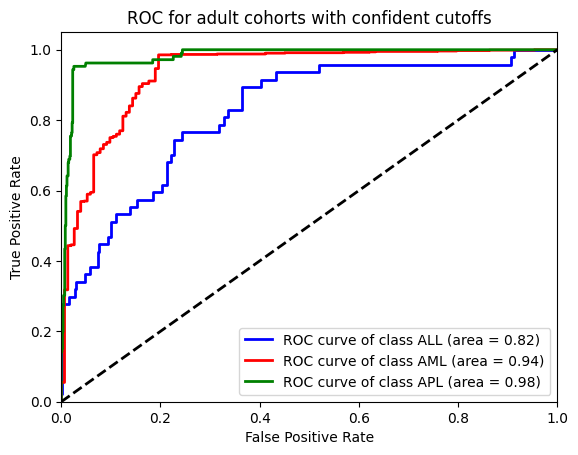

AML    821
APL    106
ALL     47
Name: class, dtype: int64

In [10]:
# ROC for confident cutoffs
cutoff = {"ALL": 0.9593636, "AML": 0.9448341, "APL": 0.7487954}
# any of the three
df = df[(df["prediction.AML"] > cutoff["AML"]) | 
        (df["prediction.ALL"] > cutoff["ALL"]) | 
        (df["prediction.APL"] > cutoff["APL"])]
classes = ["ALL", "AML", "APL"]
y = label_binarize(df['class'], classes=classes)
n_classes = y.shape[1]

# Convert predictions to a similar format for ROC calculation
y_score = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for adult cohorts with confident cutoffs')
plt.legend(loc="lower right")
plt.show()
df['class'].value_counts()
